# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread
from zipfile import ZipFile

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [2]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is present in both notebooks

# load and clean full dataset?
load_full = True

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [5]:
### load processed data

if load_full:
    
    data_zipfile = ZipFile(processed_data_train_file + ".zip")
    data = pd.read_json(data_zipfile.open(data_zipfile.namelist()[0], 'r'))
else: # not load_full
    data = pd.read_json(processed_data_train_file)

data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [6]:
x = data.drop('loan_status', 1)
y = data['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

## Step 2: Explore Data

In [7]:
image_counter = 0

In [8]:
def good_bad_quantile_plot(data, column):
    global image_counter
    
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    
    defaults = data['loan_status'] == True  # for now TODO

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 45-degree line
    ax.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    ax.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    ax.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    
    ax.set_title("QQ plot for " + column)
    ax.set_xlabel('Good loans')
    ax.set_ylabel('Bad loans')
    
    plt.show()
    
    fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
    image_counter += 1

In [9]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (174063, 32)



In [10]:
# display top rows of data set
print
data.head()

,address_state,annual_income,cpi,delinq_2_yrs,desc_len,description,dti,earliest_credit,employ_length,employ_title,gdp,home_owner,id,initial_list_status,inquiry_6_mos,installment,interest_rate,ipr,issue_date,loan_amount,loan_purpose,loan_status,loan_subgrade,loan_term,months_since_last_record,open_accounts,recoveries,revol_util,rir,total_accounts,unemploy,verif_status
1,GA,30000.0,0.021897,0,626.0,Borrower added on _number_/_number_/_number_...,0.000161,1999-04-01,0,Ryder,0.999758,RENT,1077430,f,3,59.83,15.27,0.000004,Dec-2011,2500,car,True,12,60,NaN,3,117.08,0.001511,0.000108,4,0.001093,NaN
10000,CA,115000.0,0.021984,0,230.0,Borrower added on _number_/_number_/_number_...,0.001279,1993-08-01,2,Stone & Webster Const.,0.999698,MORTGAGE,820366,f,0,585.81,10.59,0.000010,Jul-2011,18000,debt_consolidation,False,7,36,NaN,9,0.00,0.010854,0.000606,17,0.001090,NaN
100000,NH,97000.0,0.021155,0,195.0,Borrower added on _number_/_number_/_number_...,0.003259,1985-08-01,10,The Coolidge law Firm PLLC,0.999717,MORTGAGE,3349904,f,0,484.22,7.90,0.000009,Feb-2013,15475,credit_card,False,1,36,NaN,13,0.00,0.010237,0.001308,42,0.001081,NaN
100003,PA,39000.0,0.021156,0,70.0,Borrower added on _number_/_number_/_number_...,0.000922,1994-08-01,1,fncb,0.999755,MORTGAGE,3349881,f,1,59.60,15.80,0.000003,Feb-2013,1700,home_improvement,False,11,36,NaN,8,0.00,0.006385,0.000381,27,0.001082,NaN
100007,NJ,42400.0,0.021155,0,NaN,None,0.004624,1998-12-01,2,Hackensack Medical Center Mountainside,0.999715,RENT,3356410,f,0,623.30,11.14,0.000026,Feb-2013,19000,debt_consolidation,False,6,36,NaN,17,0.00,0.009941,0.000833,34,0.001081,NaN


In [11]:
# summarize data set
print
data.describe()

/Users/davidmodjeska/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,annual_income,cpi,delinq_2_yrs,desc_len,dti,gdp,id,inquiry_6_mos,installment,interest_rate,ipr,loan_amount,loan_subgrade,loan_term,months_since_last_record,open_accounts,recoveries,revol_util,rir,total_accounts,unemploy,verif_status
count,1.740630e+05,174063.000000,174063.000000,61476.000000,174063.000000,174063.000000,1.740630e+05,174063.000000,174063.000000,174063.000000,1.740630e+05,174063.000000,174063.000000,174063.000000,21304.000000,174063.000000,174063.000000,174063.000000,174063.000000,174063.000000,174063.000000,0.0
mean,7.246843e+04,0.020923,0.209976,292.766348,0.002416,0.999738,1.155373e+07,0.820645,418.289139,13.768581,1.146618e-05,13559.317316,11.171294,41.319040,76.735543,10.924631,161.772294,0.008005,0.000392,25.011025,0.000973,NaN
std,6.020325e+04,0.000698,0.514827,315.652374,0.001118,0.000041,1.359510e+07,0.968188,244.763975,4.402568,6.036392e-06,8117.058281,6.765852,9.968216,28.702901,4.880516,748.088238,0.003731,0.000331,11.741247,0.000132,NaN
min,3.000000e+03,0.019595,0.000000,1.000000,0.000000,0.992349,5.473400e+04,0.000000,19.870000,5.320000,4.790000e-08,725.000000,1.000000,36.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000705,NaN
25%,4.500000e+04,0.020243,0.000000,NaN,0.001577,0.999715,1.451468e+06,0.000000,240.220000,10.740000,6.846700e-06,7325.000000,6.000000,36.000000,NaN,7.000000,0.000000,0.005281,0.000174,16.000000,0.000880,NaN
50%,6.200000e+04,0.020924,0.000000,NaN,0.002372,0.999744,6.179411e+06,1.000000,365.230000,13.530000,1.061830e-05,12000.000000,11.000000,36.000000,NaN,10.000000,0.000000,0.008146,0.000321,23.000000,0.000977,NaN
75%,8.700000e+04,0.021466,0.000000,NaN,0.003228,0.999765,1.561990e+07,1.000000,547.120000,16.550000,1.533740e-05,18225.000000,16.000000,36.000000,NaN,14.000000,0.000000,0.010843,0.000525,32.000000,0.001082,NaN
max,8.706582e+06,0.023216,2.000000,5016.000000,0.005802,0.999807,6.860466e+07,3.000000,1424.570000,28.990000,6.533500e-05,35000.000000,34.000000,60.000000,129.000000,76.000000,33520.270000,0.121802,0.011159,150.000000,0.001244,NaN


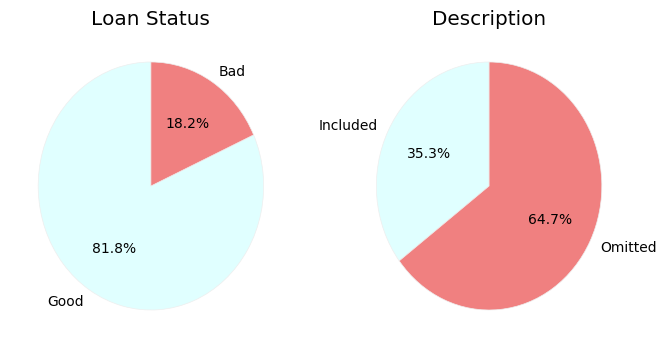

In [12]:
### plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == False).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

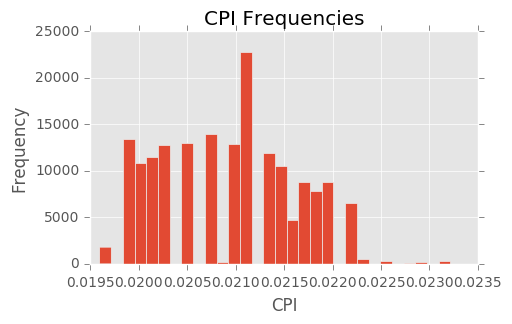

In [13]:
# plot histogram of CPI
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['cpi'], bins = 30)
ax.set_title("CPI Frequencies")
ax.set_xlabel("CPI")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

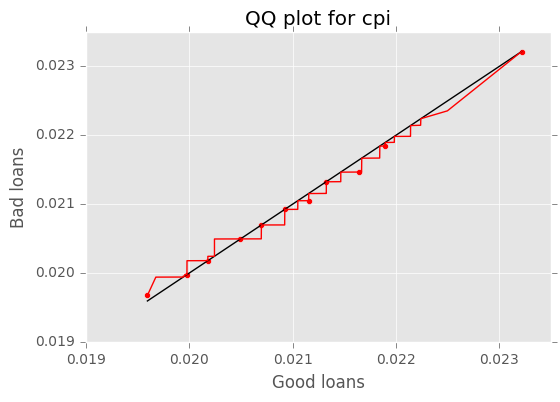

In [14]:
good_bad_quantile_plot(data, 'cpi')

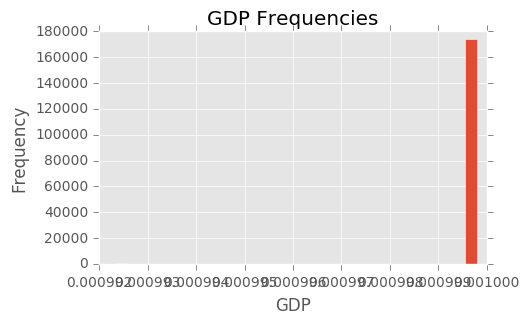

In [15]:
# plot histogram of GDP
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['gdp'] / 1000.0, bins = 30)
ax.set_title("GDP Frequencies")
ax.set_xlabel("GDP")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

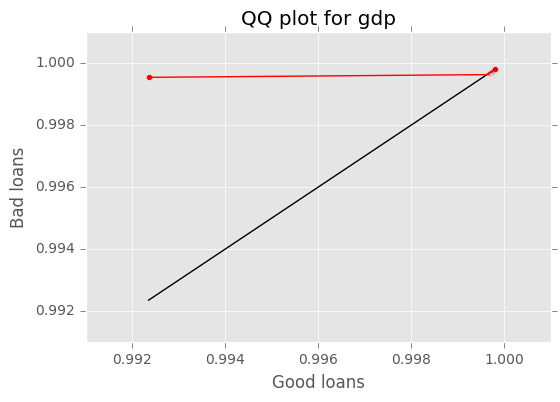

In [16]:
good_bad_quantile_plot(data, 'gdp')

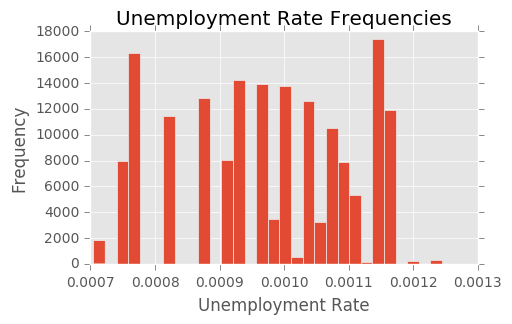

In [17]:
# plot histogram of unemployment rate
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['unemploy'], bins = 30)
ax.set_title("Unemployment Rate Frequencies")
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

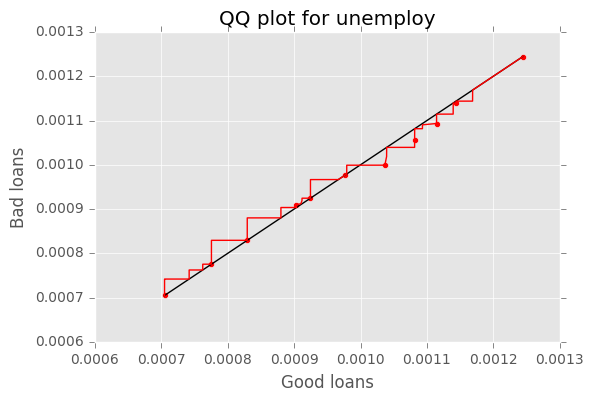

In [18]:
good_bad_quantile_plot(data, 'unemploy')

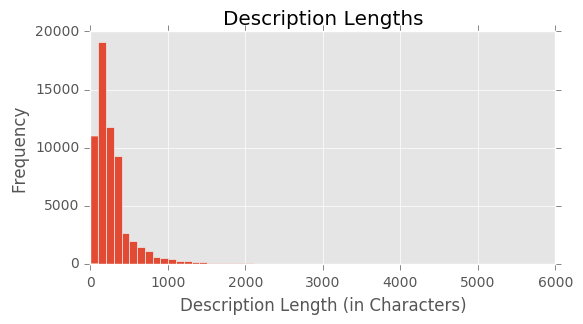

In [19]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
description_lengths = data['desc_len'][description_flags]

ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

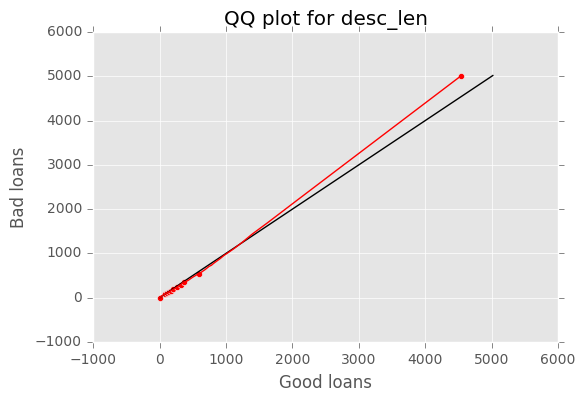

In [20]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [21]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,61476.000000
mean,292.766348
std,315.652374
min,1.000000
25%,120.000000
50%,206.000000
75%,343.000000
max,5016.000000


In [22]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.         -0.01903224]
 [-0.01903224  1.        ]]



### Text Analysis

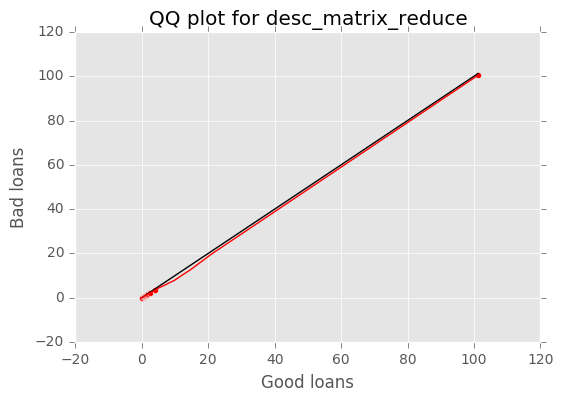

In [23]:
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

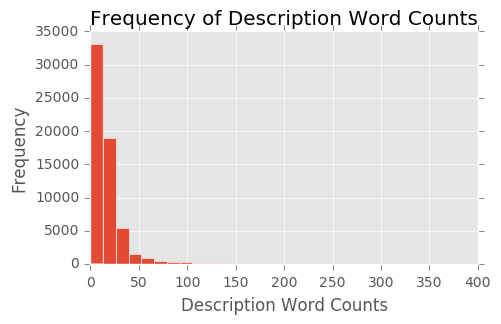

In [24]:
# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

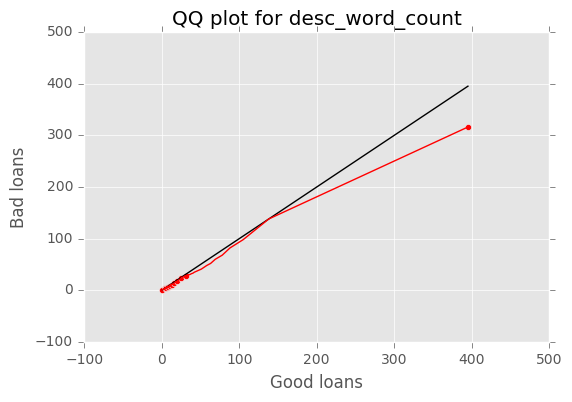

In [25]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

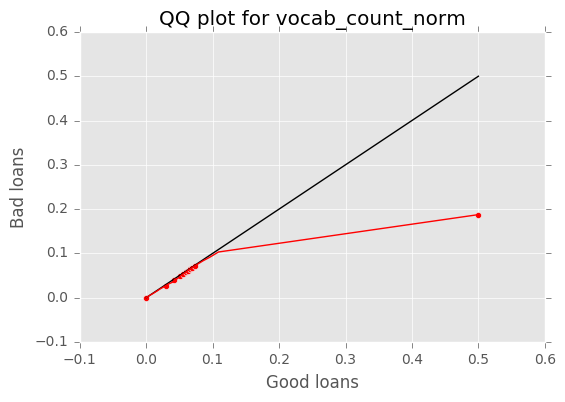

In [26]:
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

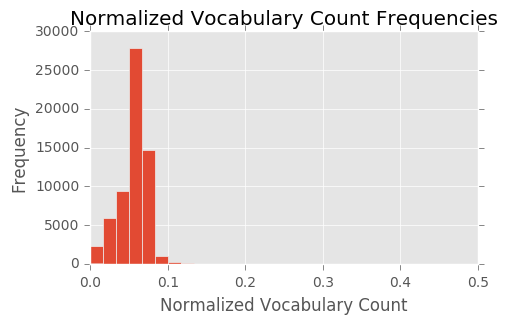

In [27]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [28]:
print desc_matrix.shape

(61476, 14079)


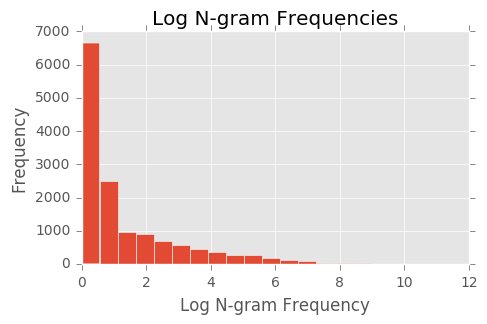

In [29]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

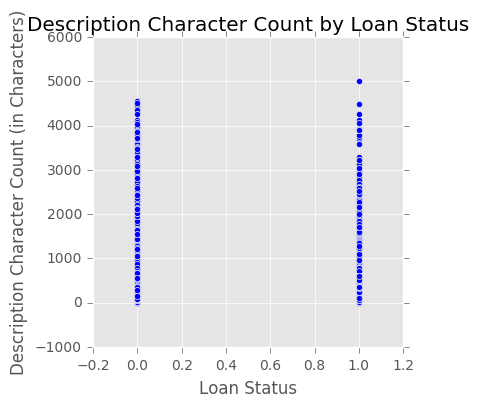

In [30]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

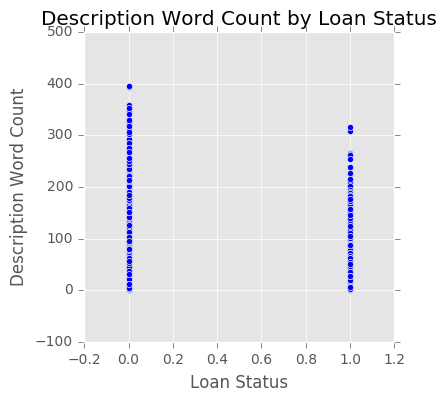

In [31]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

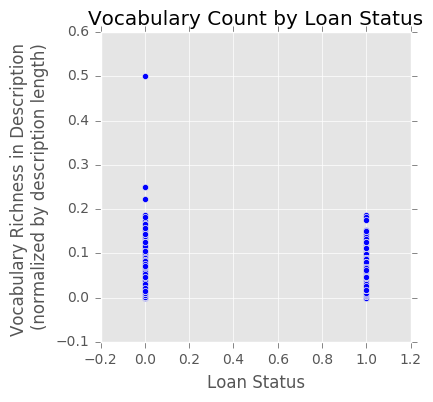

In [32]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

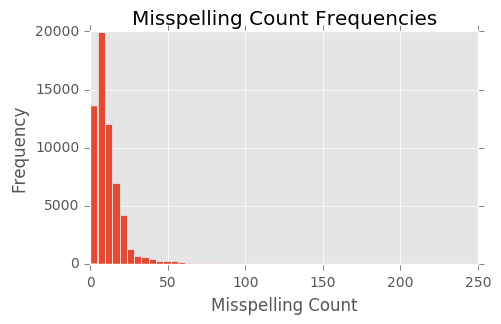

In [33]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

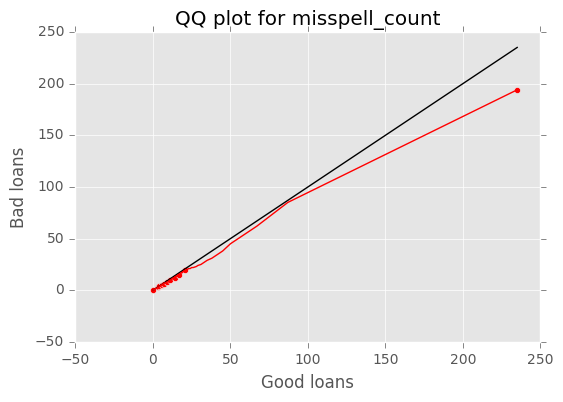

In [34]:
good_bad_quantile_plot(data_nlp, "misspell_count")

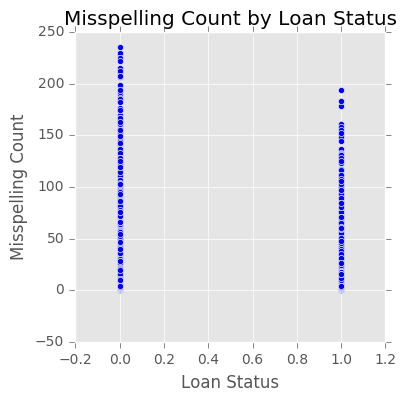

In [35]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

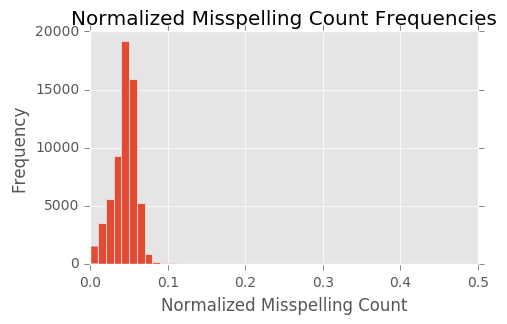

In [36]:
# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

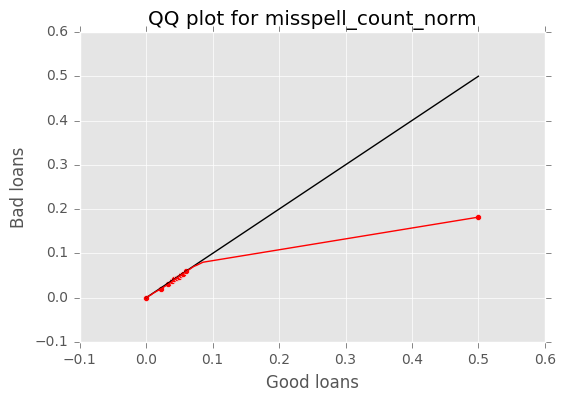

In [37]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

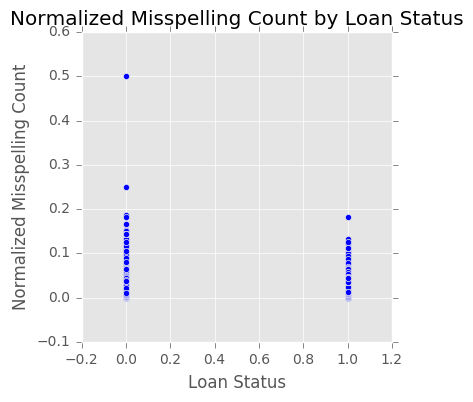

In [38]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

### Plot NLP Features

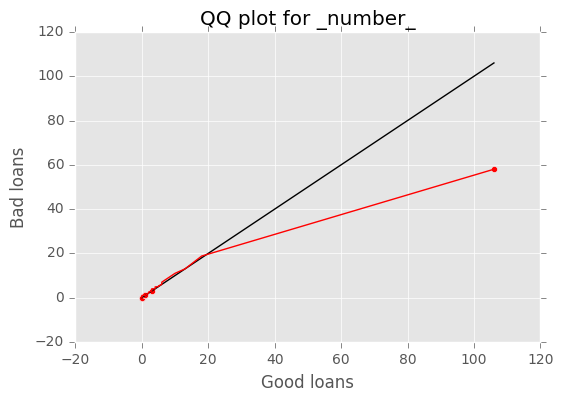

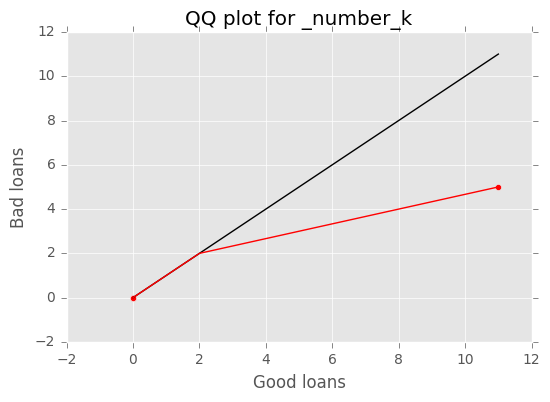

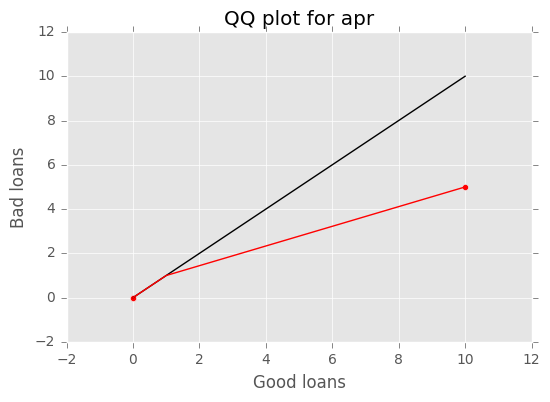

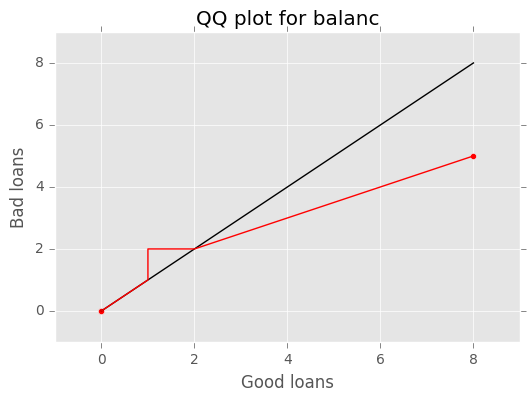

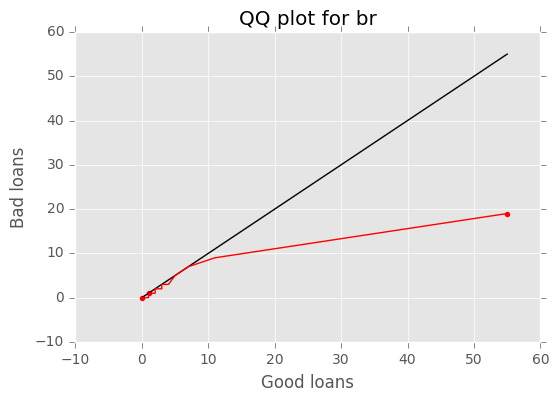

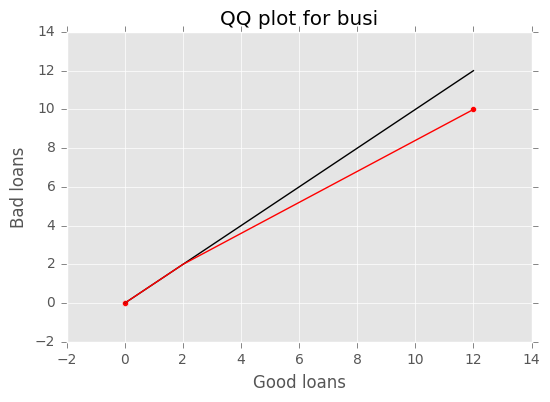

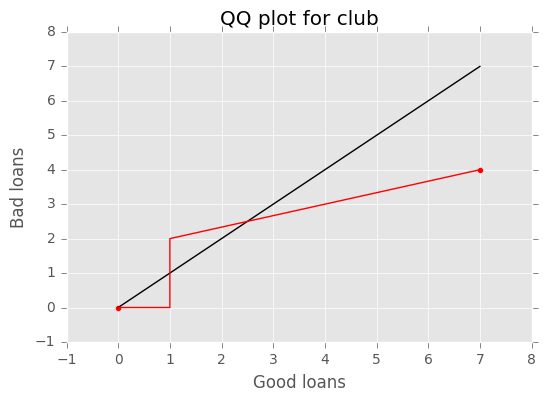

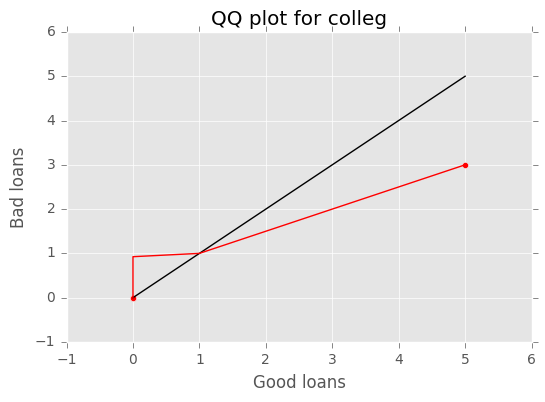

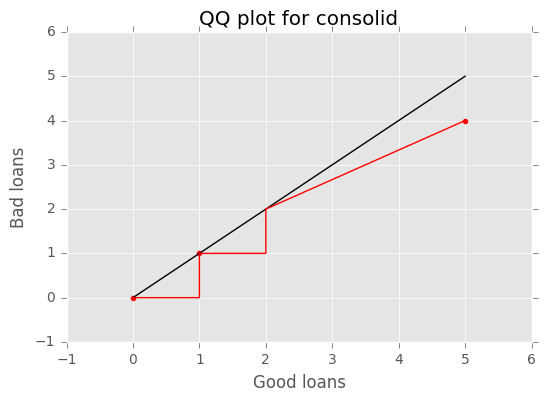

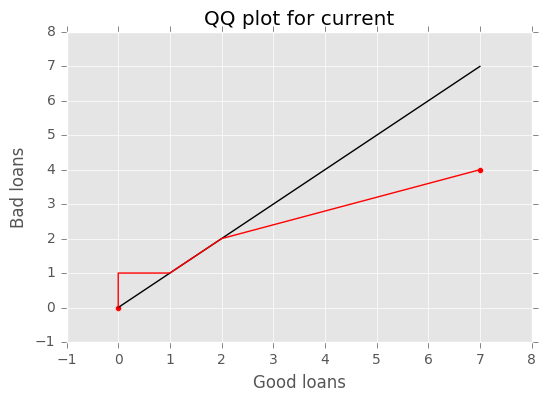

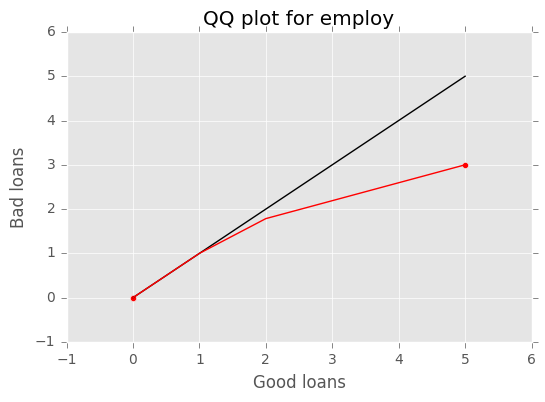

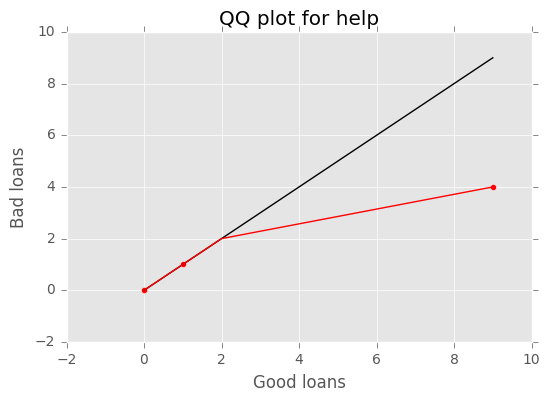

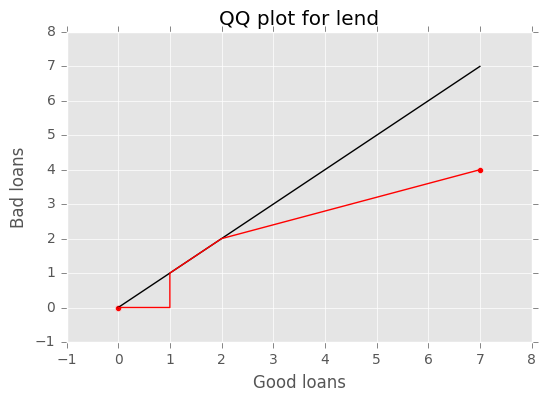

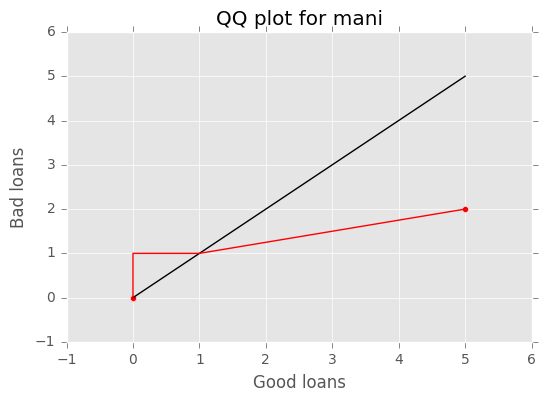

In [39]:
count_cols_qq_data = pd.concat((data_nlp['loan_status'], count_cols_df), axis = 1)
for index in range(1, count_cols_bool.shape[1] / 2):
    good_bad_quantile_plot(count_cols_qq_data, count_cols_qq_data.columns[index])

## Step 3: Model Data

In [40]:
# function to calculate expected revenue
def expected_revenue(data):
    revenue = (data['installment'] * data['loan_term']) - data['loan_amount']
    return revenue

### Baseline Models

In [41]:
# function to compute accuracy of given model on full test set, on class 0, and on class 1
score = lambda model, x_test, y_test: \
        pd.Series([model.score(x_test, y_test), 
                    model.score(x_test[y_test == 0], y_test[y_test == 0]),
                    model.score(x_test[y_test == 1], y_test[y_test == 1])],
                    index = ['Overall Accuracy', 'Accuracy on Class 0', 'Accuracy on Class 1'])

In [42]:
# function to compute revenue of given model on full test set, on class 0, and on class 1
revenue = lambda model, x, y: \
        pd.Series([model.revenue(x, y), 
                    model.revenue(x[y == 0], y[y == 0]),
                    model.revenue(x[y == 1], y[y == 1])],
                    index = ['Overall Revenue', 'Revenue for Class 0', 'Revenue for Class 1'])

In [43]:
# model that labels everything 1
class Pos_model(object):
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [44]:
# model that labels everything 0
class Neg_model(object):
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [45]:
# model that randomly labels things
class Random_model(object):
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [46]:
### score using baseline models

pos_model = Pos_model()
pos_model_scores = score(pos_model, x, y)
pos_model_revenues = revenue(pos_model, x, y)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x, y)
neg_model_revenues = revenue(neg_model, x, y)

random_model = Random_model()
random_model_scores = score(random_model, x, y)
random_model_revenues = revenue(random_model, x, y)

In [47]:
# print scores
pd.options.display.float_format = '{:,.2f}'.format
score_df = pd.DataFrame({'Positive Model': pos_model_scores,
                         'Negative Model': neg_model_scores,
                         'Random Model': random_model_scores})
print
score_df

,Negative Model,Positive Model,Random Model
Overall Accuracy,0.82,0.18,0.50
Accuracy on Class 0,1.00,0.00,0.50
Accuracy on Class 1,0.00,1.00,0.50


In [48]:
# print revenues
pd.options.display.float_format = '{:,.0f}'.format
revenue_df = pd.DataFrame({'Positive Model': pos_model_revenues,
                         'Negative Model': neg_model_revenues,
                         'Random Model': random_model_revenues})
print
revenue_df

,Negative Model,Positive Model,Random Model
Overall Revenue,"718,371,607",0,"358,762,593"
Revenue for Class 0,"538,612,814",0,"268,032,648"
Revenue for Class 1,"179,758,793",0,"90,741,430"


### Other Models

In [49]:
# define model types
log_reg = 2
lda = 3
qda = 4
knn = 5
rf = 6
boost = 7
svm = 8

In [50]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rf:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [51]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == True).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 10 ** -4, class_weight = 'balanced',
                                 penalty = 'l2', solver = 'liblinear', fit_intercept = True)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.0001)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rf:
        model_instance = RFC(n_estimators = 10, class_weight = 'balanced',
                            max_features = 'auto', max_depth = 20)
    elif model_type == boost:
        model_instance = Boost(n_estimators = 100, learning_rate = 0.4)
    elif model_type == svm:
        model_instance = SVC(C = 100, kernel = 'poly', degree = 2, class_weight = 'balanced',
                            shrinking = True)
    else:
        model_instance = None
        
    return model_instance

In [52]:
# function to fit and score one model of given type
def fit_and_score_one_model(x, y, model_type):
    np.random.seed(42)
        
    train_score_accum = 0
    test_score_accum = 0
    cm_accum = np.zeros((2, 2))
    f1_accum = 0

    n_folds = 5
    kf = KFold(x.shape[0], n_folds = n_folds)
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        
        cm_accum += confusion_matrix(y_test, y_predict)
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)
        f1_accum += f1_score(y_test, y_predict, pos_label = 1)

    # calculate accuracy
    train_score = train_score_accum / float(n_folds)
    test_score = test_score_accum / float(n_folds)
    f1_result = f1_accum / float(n_folds)

    # compute confusion matrix
    cm = cm_accum / float(n_folds)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    # output results
    model_name = get_model_name(model_type)
    print "Accuracy with " + model_name + ":"
    print "\tTraining:", round(train_score, 4)
    print "\tTesting:", round(test_score, 4)
    print
    print "Confusion Matrix:"
    display(cm_df)
    print "F1 score = ", f1_result

### NLP

In [53]:
# KNN 
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], knn)

In [54]:
# logistic regression
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.4526
	Testing: 0.4106

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"3,682","6,493"
1,Actual_good,754,"1,366"


F1 score =  0.272018582614


In [55]:
# random forests
fit_and_score_one_model(data_nlp[['misspell_count', 'desc_len']].values, 
                        data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6853
	Testing: 0.6021

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"6,602","3,573"
1,Actual_good,"1,319",801


F1 score =  0.245405903576


In [56]:
# nlp_plus = np.concatenate((count_cols_bool.toarray(), data_nlp[['loan_amount']]), axis = 1)
# fit_and_score_one_model(nlp_plus, data_nlp['loan_status'], log_reg)

In [57]:
# LDA
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], lda)

Accuracy with LDA:
	Training: 0.1724
	Testing: 0.1724

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"10,175"
1,Actual_good,0,"2,120"


F1 score =  0.293878096793


In [58]:
# # use description column with QDA to predict defaults and score accuracy
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], qda)

Accuracy with QDA:
	Training: 0.8127
	Testing: 0.802

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"9,791",384
1,Actual_good,"2,051",69


F1 score =  0.0488293968616


In [59]:
# random forests 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6563
	Testing: 0.5892

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"6,462","3,714"
1,Actual_good,"1,338",782


F1 score =  0.234078129841


In [60]:
# SVM
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], svm)

In [61]:
# boosting
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], boost)

In [62]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.4255
	Testing: 0.3871

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"3,345","6,830"
1,Actual_good,706,"1,414"


F1 score =  0.272770546802


In [63]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.42
	Testing: 0.3798

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"3,213","6,962"
1,Actual_good,664,"1,456"


F1 score =  0.266448754086


### Basic Models

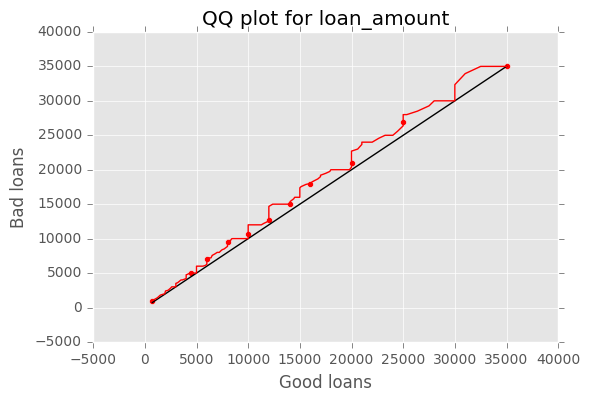

In [64]:
good_bad_quantile_plot(data, 'loan_amount')

In [65]:
# logistic regression
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.4811
	Testing: 0.4811

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"12,852","15,612"
1,Actual_good,"2,452","3,897"


F1 score =  0.300728363039


In [66]:
# random_forests
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6613
	Testing: 0.6518

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"20,171","8,293"
1,Actual_good,"3,828","2,521"


F1 score =  0.292742002791


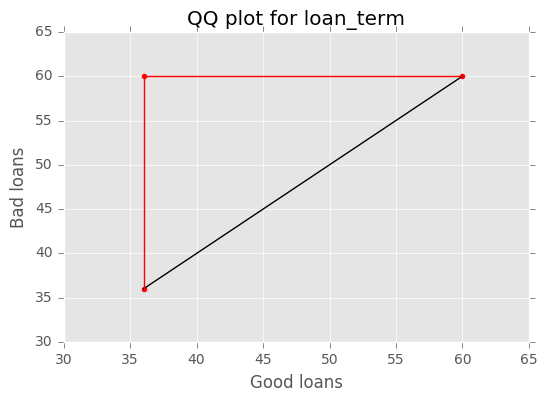

In [67]:
good_bad_quantile_plot(data, 'loan_term')

In [68]:
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.1824
	Testing: 0.1824

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"28,464"
1,Actual_good,0,"6,349"


F1 score =  0.308185900988


In [69]:
# random_forests
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7261
	Testing: 0.7261

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"23,013","5,451"
1,Actual_good,"4,084","2,265"


F1 score =  0.321597613743


In [70]:
# SVM
# fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], svm)

In [71]:
# random_forests
fit_and_score_one_model(data[['loan_amount', 'dti', 'revol_util', 'rir', 
                             'annual_income', 'loan_term']].values, 
                        data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.937
	Testing: 0.7675

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"25,436","3,027"
1,Actual_good,"5,066","1,283"


F1 score =  0.239950233674


In [72]:
# SVM
# fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], svm)

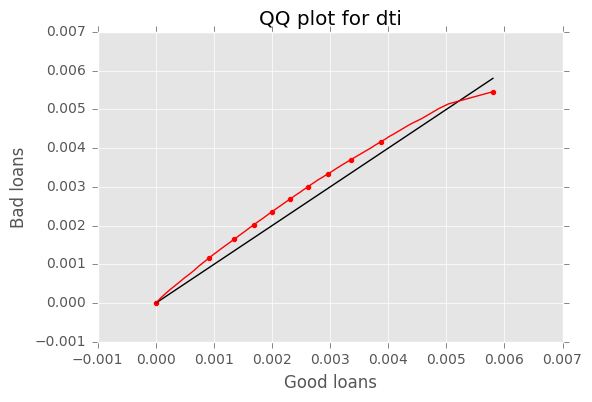

In [73]:
good_bad_quantile_plot(data, 'dti')

In [74]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6566
	Testing: 0.6175

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"18,912","9,552"
1,Actual_good,"3,766","2,583"


F1 score =  0.279092930012


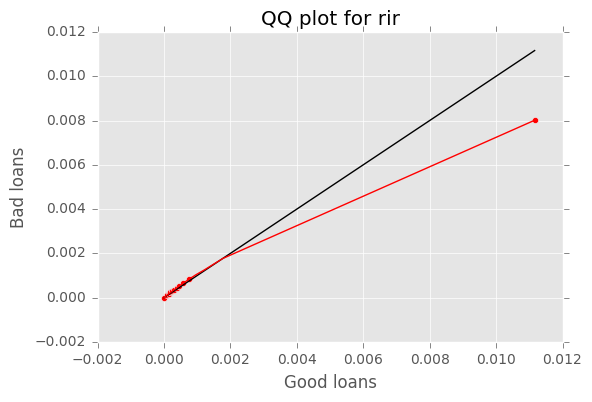

In [75]:
good_bad_quantile_plot(data, 'rir')

In [76]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6566
	Testing: 0.6175

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"18,912","9,552"
1,Actual_good,"3,766","2,583"


F1 score =  0.279092930012


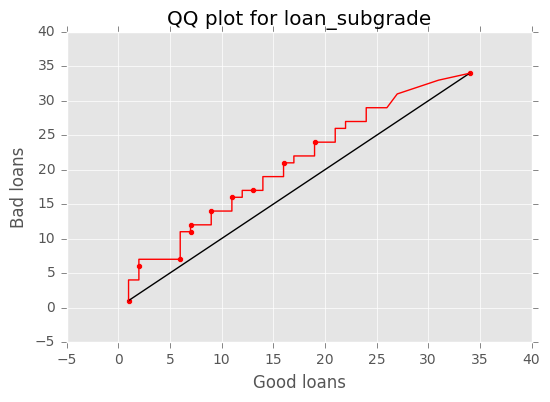

In [77]:
good_bad_quantile_plot(data, 'loan_subgrade')

In [78]:
# random_forests
fit_and_score_one_model(data[['loan_subgrade']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.587
	Testing: 0.6123

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"17,301","11,163"
1,Actual_good,"2,335","4,014"


F1 score =  0.36815626611


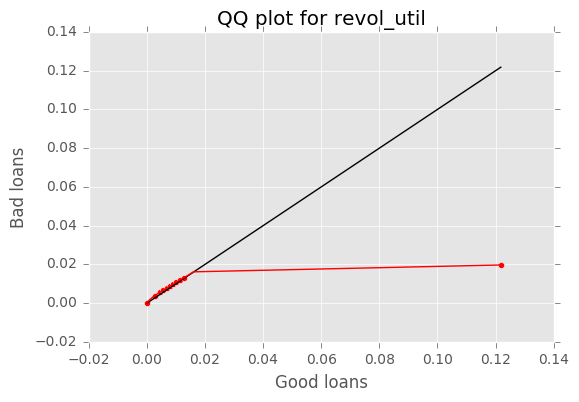

In [79]:
good_bad_quantile_plot(data, 'revol_util')

In [80]:
# random_forests
fit_and_score_one_model(data[['revol_util']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6056
	Testing: 0.591

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"17,863","10,601"
1,Actual_good,"3,637","2,712"


F1 score =  0.27404316249


### Stacking

In [81]:
### extract predictors and response
def extract_predictors_response(x, y):
    mask = np.random.rand(x.shape[0]) < 0.8

    x_train = x[mask, :]
    x_test = x[~mask, :]

    y_train = y.values[mask]
    y_test = y.values[~mask]
    
    return x_train, y_train, x_test, y_test

In [82]:
# function to create model stack
def create_model_stack(x, y):
    model_stack = []

    # logistic regression
    model = get_model_instance(log_reg, y)
    model.fit(x, y)
    model_stack.append(model)

#     # QDA
#     model = get_model_instance(qda, y)
#     model.fit(x, y)
#     model_stack.append(model)

#     # KNN
#     model = get_model_instance(knn, y)
#     model.fit(x, y)
#     model_stack.append(model)

    # random forests
    model = get_model_instance(rf, y)
    model.fit(x, y)
    model_stack.append(model)

    # # boosting
    # model = get_model_instance(boost, y)
    # model.fit(x, y)
    # model_stack.append(model)

#     # SVM
#     model = get_model_instance(svm, y)
#     model.fit(x, y)
#     model_stack.append(model)
    
    return model_stack

In [83]:
# function to fit and score a stacking ensemble
def fit_score_stacking(models, x_train, y_train, x_test, y_test, combiner, combiner_name):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(models)
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)

    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # predict with ensemble
    combiner.fit(y_train_stack, y_train)
    y_predict = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, y_predict)
    f1_result = f1_score(y_test, y_predict, pos_label = 1)
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)

    return score, cm_df, f1_result

In [84]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(x, y, combiner_type, combiner_name):

    x_train, y_train, x_test, y_test = extract_predictors_response(x, y)

    model_stack = create_model_stack(x_train, y_train)

    combiner = get_model_instance(combiner_type, y_train)

    score, cm_df, f1_result = fit_score_stacking(model_stack, x_train, y_train, 
                                                 x_test, y_test, combiner, combiner_name)

    print
    print "Accuracy with stacking by " + combiner_name + " = " + str(round(score, 4))
    print
    print "Confusion Matrix"
    display(cm_df)
    print
    print "F1 score with stacking by " + combiner_name + " = " + str(round(f1_result, 4))

In [85]:
# fit and score a stacked-model ensemble using NLP features
try_one_stacked_model(count_cols_bool, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.5865

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,6397,3713
1,Actual_good,1337,767



F1 score with stacking by random forests = 0.233


In [86]:
# fit and score a stacked-model ensemble using loan amount
try_one_stacked_model(data['loan_amount'].reshape(-1, 1), data['loan_status'], 
                      rf, "random forests")


Accuracy with stacking by random forests = 0.6571

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,20324,8106
1,Actual_good,3850,2583



F1 score with stacking by random forests = 0.3017


In [87]:
try_one_stacked_model(desc_matrix, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.3668

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,3032,7104
1,Actual_good,652,1460



F1 score with stacking by random forests = 0.2735


In [88]:
nlp_base = np.concatenate((count_cols_bool, 
                           data_nlp[['loan_amount', 'annual_income', 'rir',
                                    'revol_util', 'dti', 'loan_term']]), axis = 1)
try_one_stacked_model(nlp_base, data_nlp['loan_status'], log_reg, "logistic regression")


Accuracy with stacking by logistic regression = 0.7812

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,9074,966
1,Actual_good,1694,423



F1 score with stacking by logistic regression = 0.2413
